## Train QuickNAT
Working code! Details coming soon!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.data_utils import get_data

from quickNat_pytorch.net_api import squeeze_excitation as se

#torch.set_default_tensor_type('torch.FloatTensor')
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

params ={
    'data' : {
        'base_dir' : "datasets/coronal",
        'train_data_file' : "Data_train.h5", 
        'train_label_file' : "Label_train.h5",
        'train_class_weights_file' : "Class_Weight_train.h5",        
        'train_weights_file' : "Weight_train.h5",                
        'test_data_file' : "Data_test.h5", 
        'test_label_file' : "Label_test.h5",         
        'test_class_weights_file' : "Class_Weight_test.h5",       
        'test_weights_file' : "Weight_test.h5",
        'labels' : ['Background','Left WM','Left Cortex','Left Lateral ventricle','Left Inf LatVentricle','Left Cerebellum WM','Left Cerebellum Cortex',
                    'Left Thalamus','Left Caudate','Left Putamen','Left Pallidum','3rd Ventricle','4th Ventricle','Brain Stem','Left Hippocampus',
                    'Left Amygdala','CSF (Cranial)','Left Accumbens','Left Ventral DC','Right WM','Right Cortex','Right Lateral Ventricle',
                    'Right Inf LatVentricle','Right Cerebellum WM','Right Cerebellum Cortex','Right Thalamus','Right Caudate','Right Putamen',
                    'Right Pallidum','Right Hippocampus','Right Amygdala','Right Accumbens','Right Ventral DC']
    },
    'network' : { 
        'num_class': 33,
        'num_channels':1,
        'num_filters':64,
        'kernel_h':5,
        'kernel_w':5,
        'kernel_c': 1,
        'stride_conv':1,
        'pool':2,
        'stride_pool':2,
        'se_block' : se.SELayer.NONE, # Valid options : se.SELayer.NONE, se.SELayer.CSE, se.SELayer.SSE, se.SELayer.CSSE
        'drop_out' : 0 # Keep 0 for no dropout        
    },
    'training' : {
        'learning_rate': 1e-2,
        'train_batch_size': 2,
        'val_batch_size': 5,
        'log_nth': 50,
        'num_epochs': 10,
        'lr_scheduler_step_size': 5,
        'lr_scheduler_gamma' : 0.5,
        'exp_dir_name': 'Exp02_try3',
        'final_model_path': 'models/quicknat_model.model', 
    }
}

train_params, net_params, data_params = params['training'], params['network'], params['data']

## Load Data

In [3]:
train_data, test_data = get_data(data_params)
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 1320
Test size: 1320


## Train Model

In [39]:
from quickNat_pytorch.quickNAT import quickNAT
from quickNat_pytorch.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_params['train_batch_size'], shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=train_params['val_batch_size'], shuffle=False, num_workers=4)

quicknat_model = quickNAT(params['network'])
solver = Solver(optim_args={"lr": train_params['learning_rate']}, labels = params['data']['labels'])
solver.train(quicknat_model, train_loader, val_loader, 
             log_nth=train_params['log_nth'], 
             num_epochs=train_params['num_epochs'], 
             exp_dir_name=train_params['exp_dir_name'], 
             lr_scheduler_step_size = train_params['lr_scheduler_step_size'], 
             lr_scheduler_gamma = train_params['lr_scheduler_gamma'])

START TRAIN.
train : [iteration : 50] : 0.9295544028282166
train : [iteration : 100] : 0.9262341260910034
train : [iteration : 150] : 0.9315339922904968
train : [iteration : 200] : 0.9294889569282532
train : [iteration : 250] : 0.8605788350105286
train : [iteration : 300] : 0.8491193056106567
train : [iteration : 350] : 0.8516335487365723
train : [iteration : 400] : 0.8272868394851685
train : [iteration : 450] : 0.8220115900039673
train : [iteration : 500] : 0.7893809080123901
train : [iteration : 550] : 0.8462756276130676
train : [iteration : 600] : 0.8587787747383118
train : [iteration : 650] : 0.748051643371582
[Epoch : 1/10] : train loss = 0.9068958759307861, val loss = 0.90425642354
Saving model... models/Exp02_try3/quicknat_epoch2.model
train : [iteration : 950] : 0.8164454698562622
train : [iteration : 1000] : 0.7483702301979065
train : [iteration : 1050] : 0.8576371669769287
train : [iteration : 1100] : 0.7508323788642883
train : [iteration : 1150] : 0.7815789580345154
train : 

## Save the Model

When you are satisfied with your training, you can save the model.

In [40]:
quicknat_model.save(train_params['final_model_path'])

Saving model... models/quicknat_model.model


## Deploy Model on Test Data

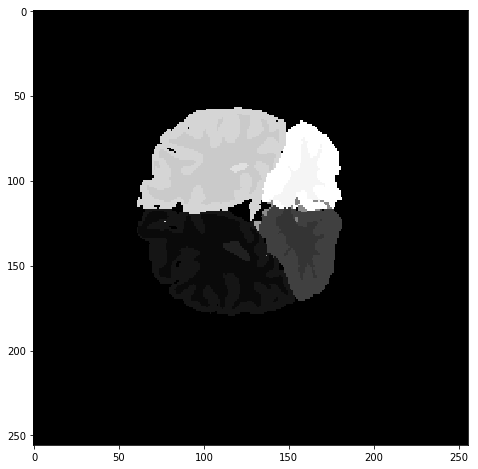

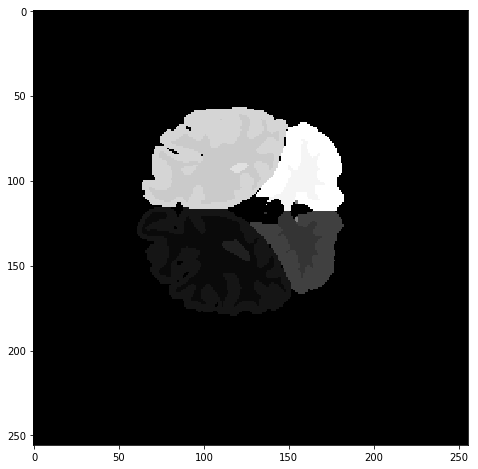

In [4]:
import matplotlib.pyplot as plt

quick_model = torch.load(train_params['final_model_path'])
with torch.no_grad():
    test_input = Variable(torch.Tensor(test_data.X[201:202]).cuda())
    out = quick_model.predict(test_input)
    
plt.imshow(out)
plt.show()

img_test = test_data.y[201:202]
img_test = np.squeeze(img_test)
plt.imshow(img_test)
plt.show()